In [77]:
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.preprocessing import LabelEncoder
import math
from timeit import default_timer as timer
import reverse_geocoder as rg
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = "{:.6f}".format

In [2]:
#yel2019 = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/yellow_tripdata_2016-06.csv")
yel2019 = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/yellow_tripdata_2016-06.csv")

In [3]:
#zones = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/taxi_zones.csv")
zones = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/taxi+_zone_lookup.csv")

In [4]:
#boros = pd.read_csv("/Users/james.fung/Downloads/nybb (1).csv")
boros = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/nybb.csv")

In [5]:
centroids = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/NHoodNameCentroids.csv")

In [6]:
yel2019.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.790000,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.000000,0.500000,0.500000,0.000000,0.000000,0.300000,7.300000
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.220000,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.000000,0.500000,0.500000,4.000000,0.000000,0.300000,27.300000
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.260000,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.500000,0.500000,0.500000,1.560000,0.000000,0.300000,9.360000
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.390000,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.000000,0.500000,0.500000,1.000000,0.000000,0.300000,28.300000
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.100000,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.500000,0.500000,0.500000,2.960000,0.000000,0.300000,17.760000
5,2,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.170000,-73.995201,40.739491,1,N,-73.993202,40.762642,1,10.500000,0.500000,0.500000,2.360000,0.000000,0.300000,14.160000
6,2,2016-06-09 21:06:36,2016-06-09 21:30:13,5,6.020000,-73.980476,40.741680,1,N,-73.902962,40.748741,2,21.500000,0.500000,0.500000,0.000000,0.000000,0.300000,22.800000
7,1,2016-06-09 21:06:37,2016-06-09 21:16:47,1,1.400000,-73.985703,40.746742,1,N,-73.982506,40.762772,1,8.500000,0.500000,0.500000,1.950000,0.000000,0.300000,11.750000
8,1,2016-06-09 21:06:37,2016-06-09 21:15:44,1,1.200000,-73.984276,40.775009,1,N,-73.968498,40.766430,2,8.000000,0.500000,0.500000,0.000000,0.000000,0.300000,9.300000
9,1,2016-06-09 21:06:37,2016-06-09 21:23:57,2,1.900000,-73.977921,40.750092,1,N,-73.987236,40.749359,1,12.000000,0.500000,0.500000,3.330000,0.000000,0.300000,16.630000


In [7]:
yel2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135470 entries, 0 to 11135469
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.6+ GB


### Functions

In [8]:
# Define a basic Haversine distance formula
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

### Preliminary Feature Extraction

Let's first extract some useful information from tpep_pickup_datetime. Things such as day of the week, day of month, month, and trip duration.

In [9]:
#Create a column for the clean date.
yel2019['clean_pickup_datetime'] = pd.to_datetime(yel2019['tpep_pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
yel2019['clean_dropoff_datetime'] = pd.to_datetime(yel2019['tpep_dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')

In [10]:
#Extract day of the week, day of month, and month.
pickup = yel2019['clean_pickup_datetime']
dropoff = yel2019['clean_dropoff_datetime']
yel2019['month'] = pickup.dt.month
yel2019['dom'] = pickup.dt.day
yel2019['dow'] = pickup.dt.dayofweek

In [11]:
#Extract the duration of the trip.
yel2019['diff_sec'] = (dropoff-pickup)/np.timedelta64(1,'s')

In [12]:
#Drop the unecessary columns.
yel2019 = yel2019.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1)

In [30]:
import datetime
#Filter to the first full week of June.
yel2019 = yel2019[(yel2019.clean_pickup_datetime >= datetime.datetime(2016,6,6)) & 
        (yel2019.clean_pickup_datetime >= datetime.datetime(2016,6,12)) &
        (yel2019.clean_dropoff_datetime >= datetime.datetime(2016,6,6)) & 
        (yel2019.clean_dropoff_datetime >= datetime.datetime(2016,6,12))]

In [31]:
yel2019.head(10)

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,clean_pickup_datetime,clean_dropoff_datetime,month,dom,dow,diff_sec
2166219,1,2,6.200000,-73.987473,40.719814,1,N,-73.982094,40.777905,1,...,4.000000,0.000000,0.300000,30.800000,2016-06-12 02:13:55,2016-06-12 02:44:21,6,12,6,1826.000000
2166220,2,3,9.960000,-73.993614,40.724579,1,N,-73.939842,40.825260,2,...,0.000000,0.000000,0.300000,32.300000,2016-06-12 02:13:55,2016-06-12 02:45:40,6,12,6,1905.000000
2166221,2,1,0.390000,-73.958977,40.712242,1,N,-73.960892,40.709236,1,...,1.260000,0.000000,0.300000,7.560000,2016-06-12 02:13:55,2016-06-12 02:18:39,6,12,6,284.000000
2166222,2,1,2.900000,-73.983215,40.726261,1,N,-74.008621,40.740536,1,...,0.000000,0.000000,0.300000,15.300000,2016-06-12 02:13:55,2016-06-12 02:33:02,6,12,6,1147.000000
2166223,1,1,3.700000,-73.978172,40.762932,1,N,-73.920715,40.743229,2,...,0.000000,0.000000,0.300000,14.300000,2016-06-12 02:13:56,2016-06-12 02:24:31,6,12,6,635.000000
2166224,1,3,1.200000,-74.002167,40.729591,1,Y,-74.006485,40.739384,2,...,0.000000,0.000000,0.300000,7.800000,2016-06-12 02:13:56,2016-06-12 02:21:02,6,12,6,426.000000
2166225,2,4,3.160000,-74.008377,40.740429,1,N,-73.974640,40.756489,1,...,2.860000,0.000000,0.300000,17.160000,2016-06-12 02:13:56,2016-06-12 02:29:00,6,12,6,904.000000
2166226,2,4,0.620000,-73.961525,40.780048,1,N,-73.967079,40.772663,1,...,1.320000,0.000000,0.300000,6.620000,2016-06-12 02:13:56,2016-06-12 02:15:28,6,12,6,92.000000
2166227,2,5,2.330000,-73.979408,40.749969,1,N,-74.007500,40.734268,1,...,2.160000,0.000000,0.300000,12.960000,2016-06-12 02:13:56,2016-06-12 02:23:34,6,12,6,578.000000
2166304,1,2,4.200000,-73.982918,40.722794,1,N,-73.991875,40.694172,1,...,2.000000,0.000000,0.300000,16.800000,2016-06-12 02:13:57,2016-06-12 02:22:47,6,12,6,530.000000


In [32]:
yel2019.shape

(6900536, 23)

### Converting Lat/Long Into Meaningful Features

In [33]:
locations = yel2019[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',]]

In [34]:
locations.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,6900536.000000,6900536.000000,6900536.000000,6900536.000000
mean,-73.049594,40.242038,-73.126172,40.285111
std,8.213192,4.524524,7.869322,4.335251
min,-118.186256,0.000000,-118.186256,0.000000
25%,-73.991821,40.736679,-73.991249,40.735050
50%,-73.981461,40.753456,-73.979462,40.754051
75%,-73.966492,40.767883,-73.962143,40.769127
max,0.000000,64.096481,0.000000,60.040714


We are only interested in Manhattan's efficiency, so let's remove trips that are outside of Manhattan.

In [35]:
yel2019 = yel2019[
    (yel2019.pickup_longitude >= -74.2563) & (yel2019.pickup_longitude <= -73.6543) &
    (yel2019.pickup_latitude >= 40.4941) & (yel2019.pickup_latitude <= 40.9313) &
    (yel2019.dropoff_longitude >= -74.2563) & (yel2019.dropoff_longitude <= -73.6543) &
    (yel2019.dropoff_latitude >= 40.4941) & (yel2019.dropoff_latitude <= 40.9313)]

In [36]:
centroids.head(5)

,the_geom,OBJECTID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough
0,POINT -73.8472005205491 40.89470517661004,1,Wakefield,1,Wakefield,NaN,NaN,0,Bronx
1,POINT -73.82993910812405 40.87429419303015,2,Co-op City,2,Co-op,City,NaN,0,Bronx
2,POINT -73.82780644716419 40.88755567735082,3,Eastchester,1,Eastchester,NaN,NaN,0,Bronx
3,POINT -73.90564259591689 40.895437426903875,4,Fieldston,1,Fieldston,NaN,NaN,0,Bronx
4,POINT -73.91258546108577 40.89083449389134,5,Riverdale,1,Riverdale,NaN,NaN,0,Bronx


In [37]:
centroids['longitude'] = pd.to_numeric(centroids.the_geom.str.replace('POINT ','').str.split(' ').str[0])
centroids['latitude'] = pd.to_numeric(centroids.the_geom.str.replace('POINT ','').str.split(' ').str[1])

In [52]:
def return_boro(latitude, longitude, centroids):
    
    index = haversine(longitude, 
                  latitude, 
                  centroids.longitude, 
                  centroids.latitude).idxmin()
    
    borough = centroids.Name.loc[index]
    
    return borough

In [53]:
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [54]:
sample = yel2019.sample(10000)

In [55]:
start = timer()
sample['pickup_boro'] = sample.parallel_apply(lambda row: 
                                       return_boro(row.pickup_latitude, row.pickup_longitude, centroids), 
                                       axis=1)
end = timer()
print(end-start)

10.015935281000566


In [56]:
sample['dropoff_boro'] = sample.parallel_apply(lambda row: 
                                       return_boro(row.dropoff_latitude, row.dropoff_longitude, centroids), 
                                       axis=1)

In [57]:
sample.head(10)

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,...,improvement_surcharge,total_amount,clean_pickup_datetime,clean_dropoff_datetime,month,dom,dow,diff_sec,pickup_boro,dropoff_boro
4446370,1,1,4.400000,-73.982201,40.776546,1,N,-73.985100,40.729053,1,...,0.300000,22.550000,2016-06-12 16:46:03,2016-06-12 17:10:31,6,12,6,1468.000000,Lincoln Square,East Village
4726811,2,2,1.420000,-73.992172,40.743671,1,N,-73.982208,40.755882,1,...,0.300000,12.090000,2016-06-13 14:34:50,2016-06-13 14:46:37,6,13,0,707.000000,Flatiron,Midtown
4557627,2,2,7.470000,-73.997833,40.751549,1,N,-73.982239,40.671452,2,...,0.300000,27.800000,2016-06-12 23:20:46,2016-06-12 23:51:41,6,12,6,1855.000000,Clinton,Windsor Terrace
8501638,2,2,1.130000,-73.958191,40.775856,1,N,-73.967857,40.762787,1,...,0.300000,8.160000,2016-06-25 13:13:22,2016-06-25 13:18:20,6,25,5,298.000000,Lenox Hill,Turtle Bay
10925554,2,3,0.760000,-73.975800,40.759235,1,N,-73.979179,40.751205,1,...,0.300000,7.560000,2016-06-21 11:22:56,2016-06-21 11:28:31,6,21,1,335.000000,Murray Hill,Murray Hill
8540306,1,3,3.200000,-73.949463,40.781013,1,N,-73.990295,40.775536,1,...,0.300000,16.800000,2016-06-25 15:21:10,2016-06-25 15:40:29,6,25,5,1159.000000,Yorkville,Lincoln Square
7196008,1,1,2.700000,-74.011940,40.707535,1,N,-73.992149,40.699226,1,...,0.300000,11.300000,2016-06-22 02:41:48,2016-06-22 02:49:49,6,22,2,481.000000,Financial District,Brooklyn Heights
7970728,2,1,1.640000,-74.003464,40.723572,1,N,-74.009178,40.738049,2,...,0.300000,10.300000,2016-06-24 02:02:52,2016-06-24 02:15:08,6,24,4,736.000000,Soho,West Village
10830521,1,1,0.700000,-73.990150,40.756527,1,N,-73.982323,40.756161,1,...,0.300000,7.800000,2016-06-21 04:22:22,2016-06-21 04:27:03,6,21,1,281.000000,Midtown South,Midtown
7367674,1,1,0.400000,-74.001816,40.746986,1,N,-74.005386,40.741787,1,...,0.300000,6.350000,2016-06-22 15:03:23,2016-06-22 15:06:57,6,22,2,214.000000,Chelsea,West Village


In [58]:
taxi_merged = sample.copy()

### Preliminary Data Cleaning

In [61]:
#Drop some unecesssary columns.
taxi_merged = taxi_merged.drop(['VendorID',
                                'clean_pickup_datetime',
                                'clean_dropoff_datetime'],axis=1)

In [62]:
#Convert some columns into factors.
factors = ['RatecodeID','payment_type','month','dom','dow']
for i in factors:
    taxi_merged[i] = taxi_merged[i].astype(object)

In [63]:
#Check out the numerical columns.
pd.options.display.float_format = "{:.2f}".format
taxi_merged.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,1.64,3.08,-73.97,40.75,-73.97,40.75,13.47,0.35,0.50,1.87,0.35,0.30,16.84,972.34
std,1.28,3.75,0.04,0.03,0.04,0.03,16.26,0.45,0.03,2.57,1.46,0.01,18.27,2760.27
min,1.00,0.00,-74.18,40.59,-74.22,40.55,-4.50,0.00,-0.50,0.00,0.00,-0.30,-5.30,0.00
25%,1.00,1.03,-73.99,40.74,-73.99,40.74,7.00,0.00,0.50,0.00,0.00,0.30,8.80,412.00
50%,1.00,1.75,-73.98,40.75,-73.98,40.75,9.50,0.50,0.50,1.35,0.00,0.30,12.30,689.00
75%,2.00,3.30,-73.97,40.77,-73.96,40.77,15.00,0.50,0.50,2.46,0.00,0.30,18.36,1131.00
max,6.00,33.60,-73.78,40.88,-73.66,40.93,1210.00,4.50,0.50,30.88,25.00,0.30,1211.30,86352.00


There are some oddities in this data. Let's do some cleanup.

In [64]:
taxi_merged = taxi_merged[taxi_merged['month']==6]
taxi_merged = taxi_merged[taxi_merged['passenger_count']>0]
taxi_merged = taxi_merged[taxi_merged['fare_amount']>0]
taxi_merged = taxi_merged[taxi_merged['tip_amount']>=0]
taxi_merged = taxi_merged[taxi_merged['diff_sec']>0]

In [65]:
taxi_merged.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec
count,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00,9997.00
mean,1.64,3.08,-73.97,40.75,-73.97,40.75,13.35,0.35,0.50,1.87,0.35,0.30,16.73,972.60
std,1.28,3.75,0.04,0.03,0.04,0.03,11.01,0.45,0.03,2.57,1.46,0.00,13.82,2760.64
min,1.00,0.00,-74.18,40.59,-74.22,40.55,0.01,0.00,0.00,0.00,0.00,0.30,0.31,2.00
25%,1.00,1.03,-73.99,40.74,-73.99,40.74,7.00,0.00,0.50,0.00,0.00,0.30,8.80,412.00
50%,1.00,1.75,-73.98,40.75,-73.98,40.75,9.50,0.50,0.50,1.35,0.00,0.30,12.30,689.00
75%,2.00,3.30,-73.97,40.77,-73.96,40.77,15.00,0.50,0.50,2.46,0.00,0.30,18.36,1131.00
max,6.00,33.60,-73.78,40.88,-73.66,40.93,125.00,4.50,0.50,30.88,25.00,0.30,150.96,86352.00


Looks a lot better except for the extreme outliers. Let's remove all rows that are greater than the 99th percentile.

In [66]:
#This is lazy coding - sorry!
numerical_cols = taxi_merged.describe().columns
for cols in numerical_cols:
    taxi_merged = taxi_merged[taxi_merged[cols]<=taxi_merged[cols].quantile(q=.99)]

In [67]:
taxi_merged.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec
count,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00
mean,1.64,2.31,-73.98,40.75,-73.98,40.75,11.05,0.34,0.50,1.52,0.13,0.30,13.85,762.87
std,1.29,2.09,0.02,0.02,0.02,0.03,6.39,0.37,0.02,1.65,0.85,0.00,7.83,487.47
min,1.00,0.00,-74.09,40.59,-74.09,40.58,0.01,0.00,0.00,0.00,0.00,0.30,0.31,2.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,6.50,0.00,0.50,0.00,0.00,0.30,8.75,395.00
50%,1.00,1.63,-73.98,40.75,-73.98,40.75,9.50,0.50,0.50,1.26,0.00,0.30,11.76,650.00
75%,2.00,2.80,-73.97,40.77,-73.96,40.77,13.50,0.50,0.50,2.26,0.00,0.30,16.56,1017.00
max,6.00,15.26,-73.78,40.80,-73.82,40.83,44.50,1.00,0.50,9.69,5.54,0.30,50.81,2568.00


In [68]:
#Any missing values?
taxi_merged.isnull().sum()

passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
month                    0
dom                      0
dow                      0
diff_sec                 0
pickup_boro              0
dropoff_boro             0
dtype: int64

### Preliminary EDA

Goal: Propose a metric or algorithm to assess the potential efficiency of aggregating rides 
from many vehicles into one, given the available data. Make realistic assumptions and any necessary simplifications and state them.

In [69]:
taxi_merged.head(10)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,dom,dow,diff_sec,pickup_boro,dropoff_boro
4446370,1,4.40,-73.98,40.78,1,N,-73.99,40.73,1,18.00,...,3.75,0.00,0.30,22.55,6,12,6,1468.00,Lincoln Square,East Village
4726811,2,1.42,-73.99,40.74,1,N,-73.98,40.76,1,8.50,...,2.79,0.00,0.30,12.09,6,13,0,707.00,Flatiron,Midtown
4557627,2,7.47,-74.00,40.75,1,N,-73.98,40.67,2,26.50,...,0.00,0.00,0.30,27.80,6,12,6,1855.00,Clinton,Windsor Terrace
8501638,2,1.13,-73.96,40.78,1,N,-73.97,40.76,1,6.00,...,1.36,0.00,0.30,8.16,6,25,5,298.00,Lenox Hill,Turtle Bay
10925554,3,0.76,-73.98,40.76,1,N,-73.98,40.75,1,5.50,...,1.26,0.00,0.30,7.56,6,21,1,335.00,Murray Hill,Murray Hill
8540306,3,3.20,-73.95,40.78,1,N,-73.99,40.78,1,15.00,...,1.00,0.00,0.30,16.80,6,25,5,1159.00,Yorkville,Lincoln Square
7196008,1,2.70,-74.01,40.71,1,N,-73.99,40.70,1,10.00,...,0.00,0.00,0.30,11.30,6,22,2,481.00,Financial District,Brooklyn Heights
7970728,1,1.64,-74.00,40.72,1,N,-74.01,40.74,2,9.00,...,0.00,0.00,0.30,10.30,6,24,4,736.00,Soho,West Village
10830521,1,0.70,-73.99,40.76,1,N,-73.98,40.76,1,5.50,...,1.00,0.00,0.30,7.80,6,21,1,281.00,Midtown South,Midtown
7367674,1,0.40,-74.00,40.75,1,N,-74.01,40.74,1,4.50,...,1.05,0.00,0.30,6.35,6,22,2,214.00,Chelsea,West Village


One of the first thoughts that comes to mind are single unit passengers who hail a taxi in the same time and same location of another single unit passenger.

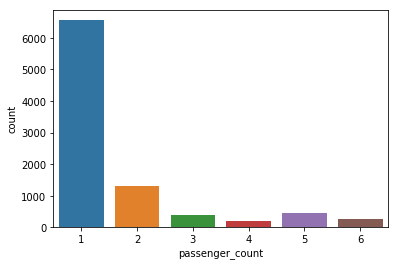

In [78]:
#What is the distribution of passenger counts?
sb.countplot(taxi_merged.passenger_count)

A majority of taxi rides are single passenger rides.